## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
#%matplotlib qt

In [2]:
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('/home/srikar/Documents/Udacity_kpit/assig_2/my_project/CarND-Advance_LaneLines-Project2/camera_cal/calibration*.jpg')
calib_images=[]
    
def calibrate_Camera_Images(images,chess_coordinate_x,chess_coordinate_y):
    # Step through the list and search for chessboard corners
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chess_coordinate_y*chess_coordinate_x,3), np.float32)
    objp[:,:2] = np.mgrid[0:chess_coordinate_x,0:chess_coordinate_y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    obj_points = [] # 3d points in real world space
    img_points = [] # 2d points in image plane.
    calib_images_array=[]
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chess_coordinate_x,chess_coordinate_y),None)

        # If found, add object points, image points
        if ret == True:
            obj_points.append(objp)
            img_points.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (chess_coordinate_x,chess_coordinate_y), corners, ret)
            #plt.figure()
            #plt.imshow(img)
            calib_images_array.append(img)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
    #cv2.destroyAllWindows()
    return obj_points,img_points,calib_images_array

chess_coordinate_x=9
chess_coordinate_y=6
objpoints,imgpoints,calib_images=calibrate_Camera_Images(images,chess_coordinate_x,chess_coordinate_y)

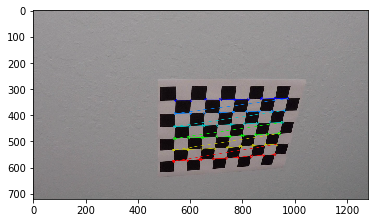

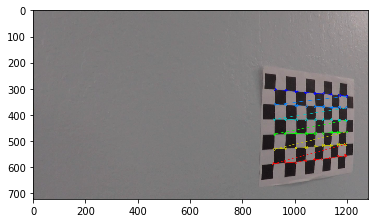

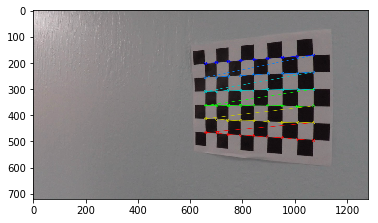

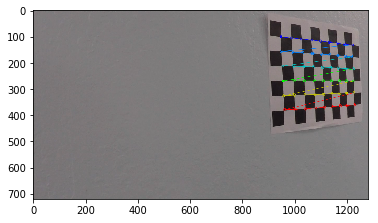

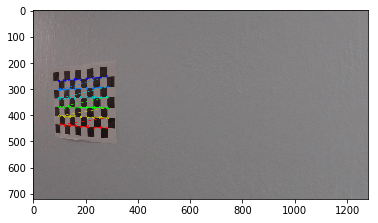

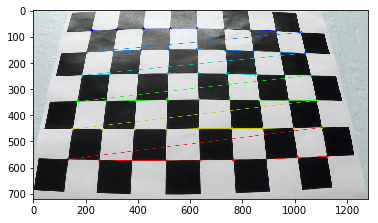

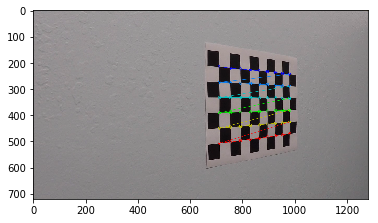

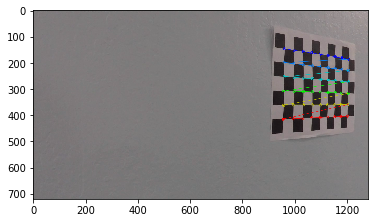

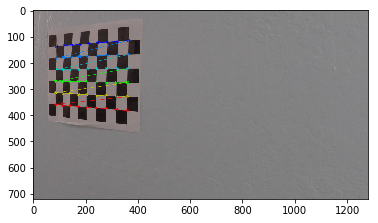

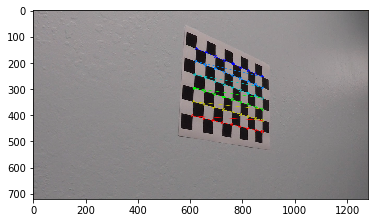

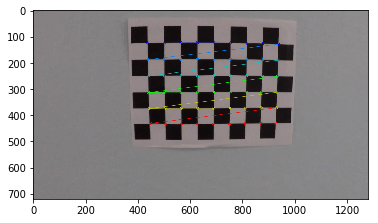

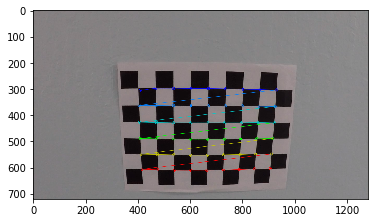

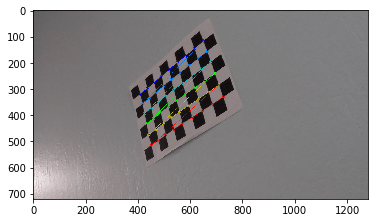

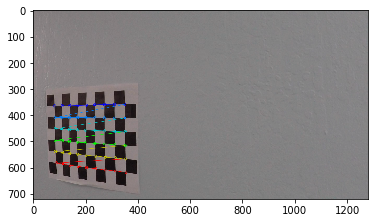

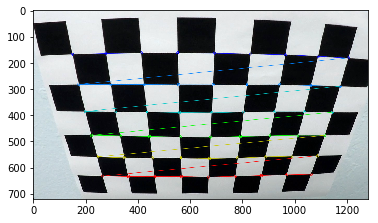

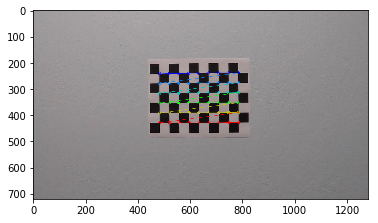

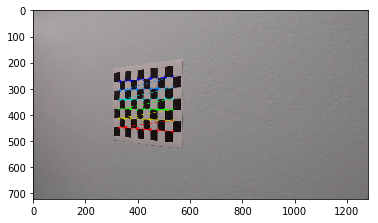

In [3]:
from PIL import Image
count=0
for img in calib_images:
    output_name = 'camera_cal_output/output_result_'+ str(count)+'.jpg'
    img = Image.fromarray(img, 'RGB')
    img.save(output_name)
    count=count+1
    plt.figure()
    plt.imshow(img)
    plt.show()
    

# Apply a distortion correction to raw images.

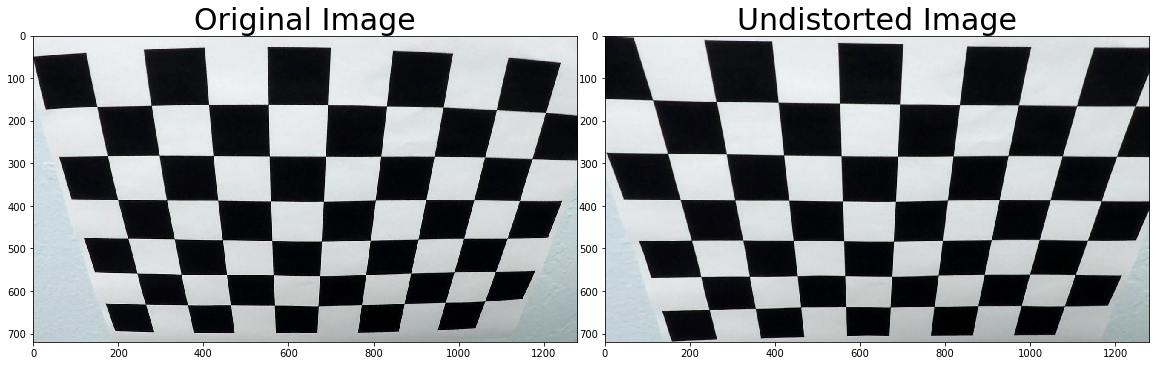

In [4]:
import pickle
#calculate distortion values
img = cv2.imread('camera_cal/calibration2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
img = Image.fromarray(img, 'RGB')
img.save('distortion_not_corrected.jpg')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
img = Image.fromarray(dst, 'RGB')
img.save('distortion_corrected.jpg')
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

# Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
#img_test = cv2.imread('test_images/test1.jpg')
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def undist_color_thresh_binary(img):
    img_test=undistort(img)
    
    #S channel
    hls_test=cv2.cvtColor(img_test,cv2.COLOR_BGR2HLS)
    s_channel=hls_test[:,:,2]
    ksize=3
    #sobel operation
    gray = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize) # Take the derivative in x
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize)
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    sobel=np.sqrt((sobelx**2)+(sobely**2))
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    
    #sobel thresholding
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    #s channel thresholding
    s_thresh_min= 150
    s_thresh_max= 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    #combined gradient + color space
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

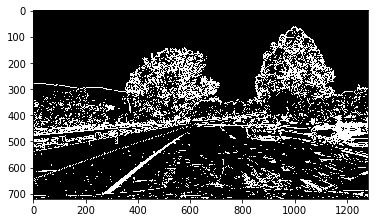

In [6]:
img_test = cv2.imread('test_images/test1.jpg')
binary=undist_color_thresh_binary(img_test)
plt.imshow(binary,cmap='gray')
plt.show()
#fig.savefig('color_gradient_thresholded.jpg')

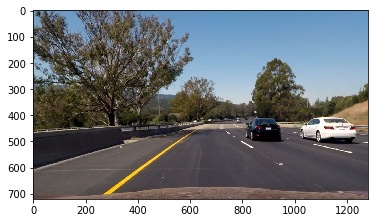

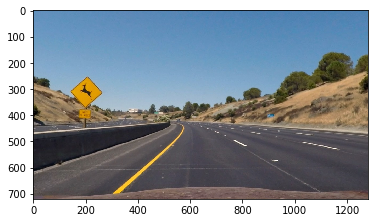

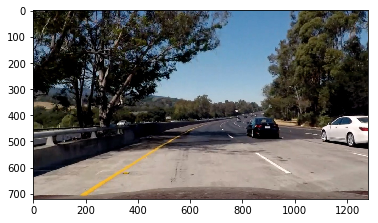

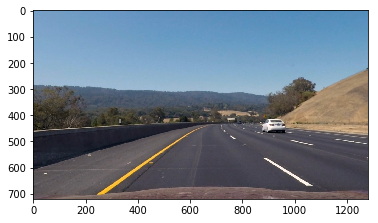

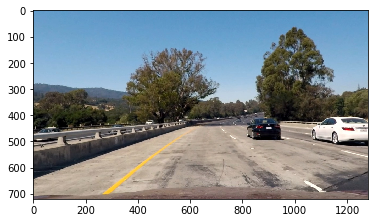

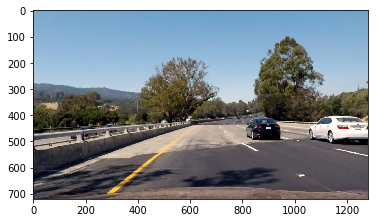


These images are undistorted


In [7]:
import matplotlib.image as mpimg 
test_images = glob.glob('test_images/test*.jpg')

for fname in test_images:
    image = mpimg.imread(fname)
    undistorted = undistort(image)
    
    plt.figure()
    plt.imshow(undistorted)
    plt.show()
    output_name = 'output_images/'+fname
    img = Image.fromarray(undistorted, 'RGB')
    img.save(output_name)

print('\nThese images are undistorted')

# Apply a perspective transform to rectify binary image ("birds-eye view").

In [10]:
img_test = cv2.imread('test_images/test1.jpg')
img_test=cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_size = (img_test.shape[1], img_test.shape[0])
binary=undist_color_thresh_binary(img_test)
src = np.float32([[600,450],[720,450],[1140,700],[260,700]])
dst = np.float32([[300,0],[900,0],[900,720],[300,720]])

In [11]:
def perspective_transf(binary_img,src,dst):
    M=cv2.getPerspectiveTransform(src,dst)
    img_size = (binary_img.shape[1], binary_img.shape[0])
    result = cv2.warpPerspective(binary_img,M,img_size)
    return result

In [12]:
warped = perspective_transf(binary,src,dst)

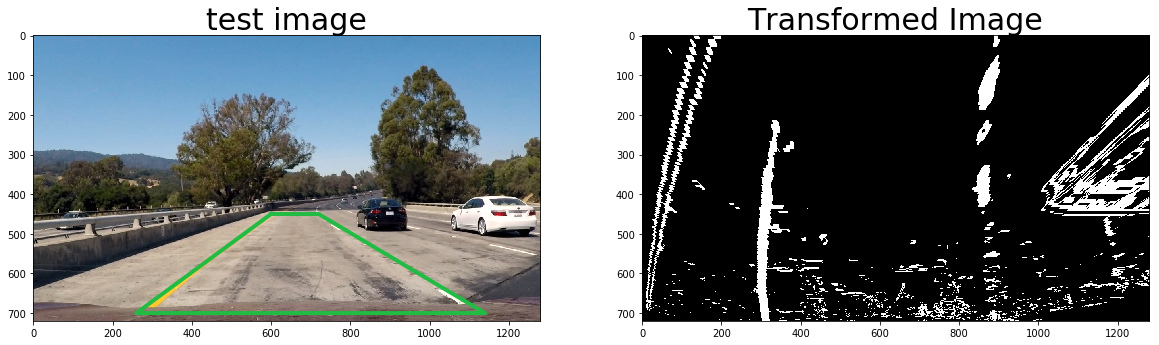

In [13]:
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ax1.plot(x, y, color='#22bb44',linewidth=4, zorder=2)
ax1.set_title('test image', fontsize=30)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Transformed Image', fontsize=30)
#f.savefig('test_image_transformed_image.jpg')
plt.show()

# Detect lane pixels and fit to find the lane boundary.

In [14]:
# Load our image
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #print(win_y_high,window,window_height)
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        #print(win_xright_high,leftx_current,margin)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)>minpix: 
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img
    
def fit_polynomial_with_plot(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,left_fit,right_fit

In [15]:
out_img,left_x_predictions,right_x_predictions,left_fit,right_fit = fit_polynomial_with_plot(warped)

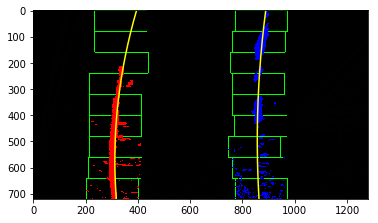

In [16]:
plt.imshow(out_img)
plt.show()
#fig.savefig('find_lane_pixels.jpg')

In [17]:
#without yellow lines
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #print(win_y_high,window,window_height)
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        #print(win_xright_high,leftx_current,margin)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)>minpix: 
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img
    
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,left_fit,right_fit

# Determine the curvature of the lane and vehicle position with respect to center.

In [18]:
#num_rows = warped.shape[0]

def measure_radius_curvature_and_center_dist(x_values,num_rows):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)
    
     # Fit new polynomials to x,y in world space
    right_fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5 / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return right_curverad
def curvature_position(left_x_predictions,right_x_predictions,num_rows):
    left_curve_rad = measure_radius_curvature_and_center_dist(left_x_predictions,num_rows)
    right_curve_rad = measure_radius_curvature_and_center_dist(right_x_predictions,num_rows)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    #curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    #print(curvature_string)

    # compute the offset from the center
    lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    #offset_string = "Center offset: %.2f m" % center_offset_mtrs
    #print(offset_string)
    return average_curve_rad,center_offset_mtrs

In [19]:
num_rows = img_test.shape[0]
average_curve_rad,center_offset_mtrs = curvature_position(left_x_predictions,right_x_predictions,num_rows)
print(average_curve_rad,center_offset_mtrs)

948.644250975 0.261953969079


# Warp the detected lane boundaries back onto the original image.

In [20]:
def detect_lane_orginal(img,warped,left_x_predictions,right_x_predictions):
    out_img = np.dstack((warped, warped, warped))*255

    y_points = np.linspace(0, num_rows-1, num_rows)

    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))

    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

    M_inv = cv2.getPerspectiveTransform(dst, src)

    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.5, 0)
    return result

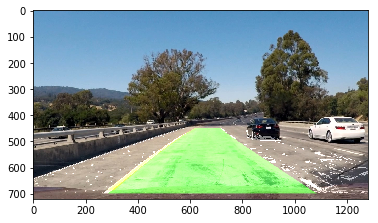

In [21]:
result=detect_lane_orginal(img_test,warped,left_x_predictions,right_x_predictions)
plt.imshow(result)
plt.show()
#fig.savefig('warp_detected_lane.jpg')

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [22]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return new_img

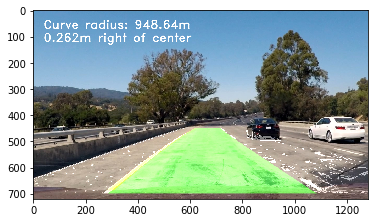

In [23]:
exampleImg_out2 = draw_data(result, average_curve_rad, center_offset_mtrs)
plt.imshow(exampleImg_out2)
plt.show()
#fig.savefig('lane_boundary_curvature_position.jpg')

In [24]:
#inputframe
#undistort
#color+gradient
#transform
#find lane using histogram
#find the radius and center
#inverse transform
#mark the road
images = cv2.imread('test_images/test2.jpg')
src = np.float32([[610,450],[710,450],[1125,700],[270,700]])
dst = np.float32([[300,0],[900,0],[900,720],[300,720]])
img_size = (images.shape[1], images.shape[0])
num_rows = images.shape[0]

In [25]:
def process_image(img):
    #img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    binary=undist_color_thresh_binary(img)
    warped = perspective_transf(binary,src,dst)
    out_img,left_x_predictions,right_x_predictions,left_fit,right_fit = fit_polynomial(warped)
    average_curve_rad,center_offset_mtrs = curvature_position(left_x_predictions,right_x_predictions,num_rows)
    result=detect_lane_orginal(img,warped,left_x_predictions,right_x_predictions)
    output = draw_data(result, average_curve_rad, center_offset_mtrs)
    return output

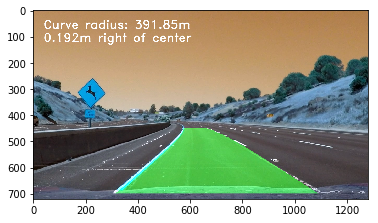

In [26]:

output=process_image(images)
plt.imshow(output)
plt.show()

In [27]:
white_output = 'test_videos_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:33<00:00,  8.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 6min 47s, sys: 11.8 s, total: 6min 59s
Wall time: 2min 33s


In [28]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [29]:

challenge_output = 'test_videos_output/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [00:56<00:00,  8.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 2min 31s, sys: 4.86 s, total: 2min 36s
Wall time: 57.2 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [31]:
harder_challenge = 'test_videos_output/harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:01<00:00,  7.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

CPU times: user 7min 20s, sys: 12.8 s, total: 7min 33s
Wall time: 3min 2s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge))